## BO with Derivatives

This tutorial demonstrates how to use gradient information in Bayesian Optimization. Traditionally, Bayesian Optimization is a zeroth-order method that does not utilize gradient information because oftentimes the black-box functions being optimized does not provide gradients. However, there may be some cases where gradient information is available [1]. As a result, derivative-enabled Bayesian Optimization may use the additional gradient information. We will call zeroth-order Bayesian Optimization ZOBO and first-order Bayesian Optimization FOBO.

The key differences between FOBO and ZOBO are that FOBO uses a modified Gaussian Process which uses derivative information (dGP) and the acquisition functions need to be able to handle a dGP [2].

In this notebook, we use the Noisy Expected Improvement (qNEI) and Knowledge Gradient (qKG) acquisition functions on a dGP which is trained on evaluations from the 3D Rosenbrock function [3].

[1]: [Quentin Bertrant, et al. Implicit Differentiation for Fast Hyperparameter Selection in Non-Smooth Convex Learning. Journal of Machine Learning Research, 2022.](https://dl.acm.org/doi/pdf/10.5555/3586589.3586738)  
[2]: [Jian Wu, et al. Bayesian Optimization with Gradients. 31st Conference on Neural Information Processing Systems, 2017.](https://proceedings.neurips.cc/paper/2017/file/64a08e5f1e6c39faeb90108c430eb120-Paper.pdf)  
[3]: [Frazier, Peter I. "A tutorial on Bayesian optimization." arXiv preprint arXiv:1807.02811 (2018).](https://arxiv.org/pdf/1807.02811.pdf%C2%A0)

In [1]:
# Imports
import os

import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

from botorch import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.acquisition import qKnowledgeGradient, qNoisyExpectedImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.models.gpytorch import GPyTorchModel
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.models.model import FantasizeMixin
from botorch.models.gpytorch import GPyTorchModel

from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood


In [2]:
# Set default data type to avoid numerical issues from low precision
torch.set_default_dtype(torch.double)

# Set seed for consistency and good results
seed = 3
torch.manual_seed(seed)
np.random.seed(seed)


In [3]:
# Used to test the notebook quickly
SMOKE_TEST = os.environ.get("SMOKE_TEST")

# Parameters
f_noise = 0.05 # Noise added to both function evaluations and their gradients
rs_init = 10 # Initialization points from random search
rb_dim = 3 # Rosenbrock dimensions
d_min = -2. # Lower bound of search space for each dimension of the domain
d_max = 2. # Upper bound of search space for each dimension of the domain
bo_iters = 40 if not SMOKE_TEST else 2 # Number of iterations of Bayesian Optimization
mc_samples = 256 if not SMOKE_TEST else 32 # Samples from Monte-Carlo sampler


## The Generalized Rosenbrock's Function

We use the [Generalized Rosenbrock's Function](https://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/optimize.html#unconstrained-minimization-of-multivariate-scalar-functions-minimize) because it has a unique global minimum at $x_0=(1.0,1.0,1.0)$ with $f(x_0)=0.0$ when working in $3$ dimensions. Since Bayesian Optimization is typically concerned with maximizing an objective function, we augment the Rosenbrock function $f(x)$ by creating $g(x)=-f(x)$, the augmented Rosenbrock function. Further, we use backpropogation to calculate the gradient of the Rosenbrock function for each input $x$.

The variant of the Rosenbrock function used here is:
$$f(\boldsymbol{x}) = \sum_{i=1}^{d-1} \left [ 100(x_{i+1}-x_{i}^{2}) + (1-x_i)^2 \right ], \quad \boldsymbol{x} \in \mathbb{R}^d$$

In [4]:
# Rosenbrock function multiplied by -1 to make this a maximization problem
# Note: This only evaluates a single X at a time (not a vectorized function)
def Rosenbrock(X):
    # Cast to calculate gradient
    X.requires_grad_(True)
    
    # Get dimensions
    N = X.shape[0]
    
    # Vector containing individual values in summation
    cur_sum = torch.zeros_like(torch.empty(N-1))
    
    # Evaluate generaled N-dimensional Rosenbrock function
    for i in range(0,N-1):
        cur_sum[i] = 100*(X[i+1]-X[i]**2)**2+(1-X[i])**2
        
    # Compute sum
    Y = torch.sum(cur_sum)
    
    # Make this a maximization problem!
    Y = -1*Y
    
    # Calculate gradient
    Y.backward()
    grads = X.grad
    
    # Convert to doubles for better numerical stability
    Y = Y.to(torch.double).detach()
    grads = grads.to(torch.double)
    
    # Add noise to evaluation and gradient
    grads += torch.normal(0,1,grads.shape)*f_noise
    Y += torch.normal(0,1,Y.shape)*f_noise
    
    # Return function value and the gradient
    return Y, grads

## Derivative-enabled Gaussian Process (dGP)

We create a custom BoTorch dGP model using GPyTorch. This model requires modifying the mean and covariance matrix to incorporate gradient/derivative information. As such, a mean *vector* and the covariance matrix of the RBF kernel are used [2]. This class was modified from this [GPyTorch tutorial](https://docs.gpytorch.ai/en/latest/examples/08_Advanced_Usage/Simple_GP_Regression_Derivative_Information_1d.html). 


In [5]:
# Define the dGP
class GPWithDerivatives(GPyTorchModel, gpytorch.models.ExactGP, FantasizeMixin):
    def __init__(self, train_X, train_Y):
        # Dimension of model
        dim = train_X.shape[-1] 
        # Multi-dimensional likelihood since we're modeling a function and its gradient
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=1 + dim)
        super().__init__(train_X, train_Y, likelihood)
        # Gradient-enabled mean
        self.mean_module = gpytorch.means.ConstantMeanGrad() 
        # Gradient-enabled kernel
        self.base_kernel = gpytorch.kernels.RBFKernelGrad( 
            ard_num_dims=dim, # Separate lengthscale for each input dimension
        )
        # Adds lengthscale to the kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        # Output dimension is 1 (function value) + dim (number of partial derivatives)
        self._num_outputs = 1 + dim
        # Used to extract function value and not gradients during optimization
        self.scale_tensor = torch.tensor([1.0] + [0.0]*dim, dtype=torch.double)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

## Random Search

To initialize our GP we obtain initialization data using random search on the optimization domain $[-2,2]^3$.

In [6]:
# Random search locations
train_X = torch.rand((rs_init, rb_dim))*(d_max - d_min)+d_min

# Populate random search evaluations
train_Y = torch.empty((rs_init, rb_dim + 1))
for i in range(rs_init):
    obj, deriv = Rosenbrock(train_X[i])
    train_Y[i][0] = obj
    train_Y[i][1:] = deriv


## qNEI FOBO Loop

Here we have the FOBO loop with the qNEI acquisition function on a dGP. Note that we have to include a `ScalarizedPosteriorTransform` to ensure that we're optiming over the black-box function's function evaluation instead of its gradients (since the output of the dGP is a mean vector of the black-box function's value and gradients, as opposed to a mean scalar of just the black-box function's value). Also, we scale the domain and range of the training data [to avoid numerical issues](https://github.com/pytorch/botorch/issues/1745).

In [ ]:
for i in range(bo_iters):
    # Standardize domain and range, this prevents numerical issues
    mean_Y = train_Y.mean(dim=0)
    std_Y = train_Y.std(dim=0)
    unscaled_train_Y = train_Y
    scaled_train_Y = (train_Y - mean_Y) / std_Y
    
    mean_X = train_X.mean(dim=0)
    std_X = train_X.std(dim=0)
    unscaled_train_X = train_X
    scaled_train_X = (train_X - mean_X) / std_X

    # Initialize the dGP and fit it to the training data
    dGP_model = GPWithDerivatives(scaled_train_X, scaled_train_Y) # Define dGP model
    mll = ExactMarginalLogLikelihood(dGP_model.likelihood, dGP_model) # Define MLL
    fit_gpytorch_mll(mll, max_attempts=20)

    # Extract only the function value from the multi-output GP, the dGP
    scal_transf = ScalarizedPosteriorTransform(weights=dGP_model.scale_tensor)

    # Create qNEI acquisition function
    sampler = SobolQMCNormalSampler(mc_samples)
    qNEI = qNoisyExpectedImprovement(dGP_model,\
                train_X,\
                sampler,\
                posterior_transform=scal_transf)

    # Set bounds for optimization: [-2,2]^d
    bounds = torch.vstack([torch.tensor([d_min]*rb_dim),\
                           torch.tensor([d_max]*rb_dim)])

    # Rescale bounds based on training data
    bounds = (bounds - mean_X) / std_X

    # Get candidate point for objective
    candidates, _ = optimize_acqf(
        acq_function=qNEI,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 1, "maxiter": 1000},
    )

    # Rescale candidate back to original domain
    candidate = (candidates[0]  * std_X) + mean_X
    
    # Evaluate the objective and add it to the list of data for the model
    obj, deriv = Rosenbrock(candidate)
    new_Y = torch.cat([obj.unsqueeze(0),deriv])
    
    # Append evaluation to training data
    train_X = torch.vstack((train_X, candidate)).detach().clone()
    train_Y = torch.vstack((train_Y, new_Y)).detach().clone()


## Plot Results

From plotting the results we see that derivative-enabled Bayesian Optimization is able to utilize gradient information to maximize the objective function.

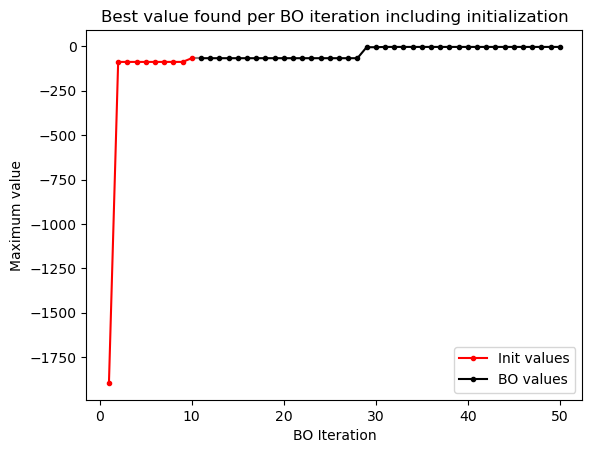

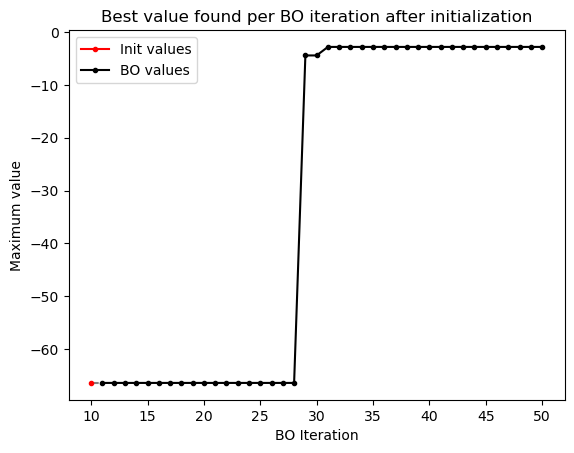

In [8]:
# Extract maximum value per iteration
maxima = torch.zeros(rs_init + bo_iters)
cur_max = train_Y[0][0]

for i in range(rs_init + bo_iters):
    cur_max = cur_max if cur_max > train_Y[i][0] else train_Y[i][0]
    maxima[i] = cur_max

# Get plotting values
plt_y = maxima.numpy()
plt_x = list(range(1,len(plt_y)+1))

# Have the first x-value in the plot start at 1 to be consistent with above prints
plt_y = np.hstack([plt_y])
plt_x = np.hstack([plt_x])

# Plot all values
plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[0:rs_init], plt_y[0:rs_init], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="BO values", marker='.')
plt.xlabel("BO Iteration")
plt.ylabel("Maximum value")
plt.title("Best value found per BO iteration including initialization")
plt.legend()
plt.show()
plt.close()

plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[rs_init-1], plt_y[rs_init-1], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="BO values", marker='.')
plt.xlabel("BO Iteration")
plt.ylabel("Maximum value")
plt.title("Best value found per BO iteration after initialization")
plt.legend()
plt.show()
plt.close()


## qKG FOBO Loop

Here we have the same FOBO loop, but with the qKG acquisition function.


In [ ]:
# Reset training data to the same as for qNEI
train_X = train_X[0:rs_init]
train_Y = train_Y[0:rs_init]

for i in range(bo_iters):
    # Standardize domain and range, this prevents numerical issues
    mean_Y = train_Y.mean(dim=0)
    std_Y = train_Y.std(dim=0)
    unscaled_train_Y = train_Y
    scaled_train_Y = (train_Y - mean_Y) / std_Y
    
    mean_X = train_X.mean(dim=0)
    std_X = train_X.std(dim=0)
    unscaled_train_X = train_X
    scaled_train_X = (train_X - mean_X) / std_X

    # Initialize the dGP and fit it to the training data
    dGP_model = GPWithDerivatives(scaled_train_X, scaled_train_Y) # Define dGP model
    mll = ExactMarginalLogLikelihood(dGP_model.likelihood, dGP_model) # Define MLL
    fit_gpytorch_mll(mll, max_attempts=20)

    # Extract only the function value from the multi-output GP, the dGP
    scal_transf = ScalarizedPosteriorTransform(weights=dGP_model.scale_tensor)

    # Create the qKG acquisition function
    qKG = qKnowledgeGradient(dGP_model,\
                posterior_transform=scal_transf,\
                num_fantasies=5)

    # Set bounds for optimization: [-2,2]^d
    bounds = torch.vstack([torch.tensor([d_min]*rb_dim),\
                           torch.tensor([d_max]*rb_dim)])

    # Rescale domain based on training data
    bounds = (bounds - mean_X) / std_X

    # Get candidate point for objective
    candidates, _ = optimize_acqf(
        acq_function=qKG,
        bounds=bounds,
        q=1,
        num_restarts=100,
        raw_samples=512,  # used for intialization heuristic
        options={"batch_limit": 1, "maxiter": 1000},
    )

    # Rescale candidate back to original domain
    candidate = (candidates[0]  * std_X) + mean_X
    
    # Evaluate the objective and add it to the list of data for the model
    obj, deriv = Rosenbrock(candidate)
    new_Y = torch.cat([obj.unsqueeze(0),deriv])
    
    # Append evaluation to training data
    train_X = torch.vstack((train_X, candidate)).detach().clone()
    train_Y = torch.vstack((train_Y, new_Y)).detach().clone()


## Plot Results

From plotting the results we see that derivative-enabled Bayesian Optimization is able to find better maxima values.

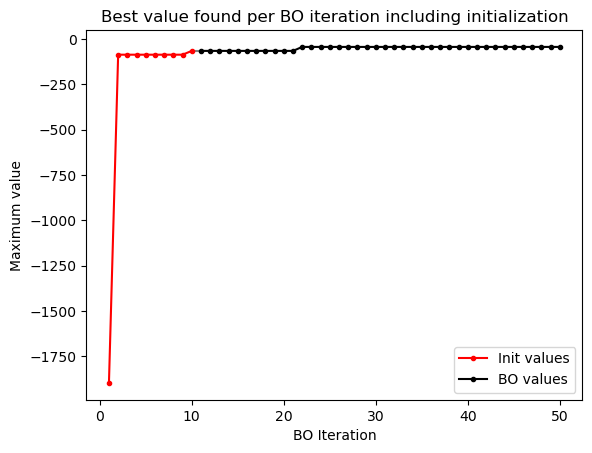

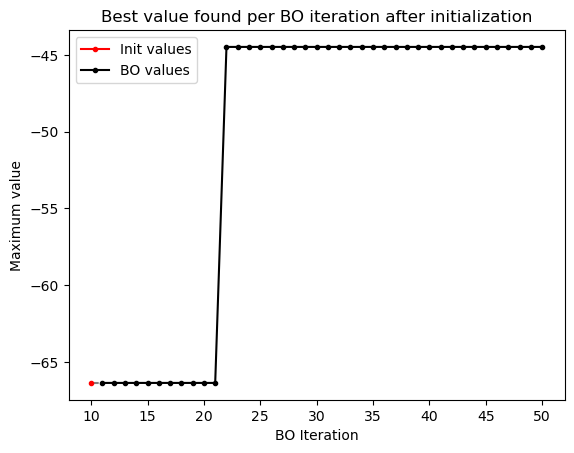

In [10]:
# Extract maximum value per iteration
maxima = torch.zeros(rs_init + bo_iters)
cur_max = train_Y[0][0]

for i in range(rs_init + bo_iters):
    cur_max = cur_max if cur_max > train_Y[i][0] else train_Y[i][0]
    maxima[i] = cur_max

# Get plotting values
plt_y = maxima.numpy()
plt_x = list(range(1,len(plt_y)+1))

# Have the first x-value in the plot start at 1 to be consistent with above prints
plt_y = np.hstack([plt_y])
plt_x = np.hstack([plt_x])

# Plot all values
plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[0:rs_init], plt_y[0:rs_init], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="BO values", marker='.')
plt.xlabel("BO Iteration")
plt.ylabel("Maximum value")
plt.title("Best value found per BO iteration including initialization")
plt.legend()
plt.show()
plt.close()

plt.plot([plt_x[rs_init-1], plt_x[rs_init]], [plt_y[rs_init-1], plt_y[rs_init]],\
         linestyle='--', color='gray')
plt.plot(plt_x[rs_init-1], plt_y[rs_init-1], color='red', label="Init values", marker='.')
plt.plot(plt_x[rs_init:], plt_y[rs_init:], color='black', label="BO values", marker='.')
plt.xlabel("BO Iteration")
plt.ylabel("Maximum value")
plt.title("Best value found per BO iteration after initialization")
plt.legend()
plt.show()
plt.close()